In [1]:
%matplotlib notebook

import os, glob, sys, tqdm
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

sys.path.append('utils')
import step02_novosparc_Wagner2HCR as funcs

from importlib import reload
reload(funcs)

<module 'step02_novosparc_Wagner2HCR' from 'utils\\step02_novosparc_Wagner2HCR.py'>

In [2]:
hpf = 12

hpf_scrna = hpf
if hpf == 12:
    hpf_scrna = 14
    
print(hpf, hpf_scrna)
scrnaseq_folder = os.path.join('..','zebrafish_Wagner_data')
scrnaseq_file = glob.glob(os.path.join(scrnaseq_folder,'*_hvg_%02dhpf.h5ad'%hpf_scrna))[0]

hcr_file = os.path.join('..','HCR_time_course','hpf'+str(hpf)+'_synthetic_HCR.h5')

print(scrnaseq_file)
print(hcr_file)

12 14
..\zebrafish_Wagner_data\WagnerScience2018_hvg_14hpf.h5ad
..\HCR_time_course\hpf12_synthetic_HCR.h5


# Load cells from HCR dataset

Load HCR dataset, filter for high density cells (removing yolk) and adjust name of prdm1->prdm1a

In [3]:
adata_hcr_all = funcs.load_scrnaseq( hcr_file )[0]

# remove cells on the yolk (probably not present in the scrnaseq dataset)
adata_hcr = adata_hcr_all[adata_hcr_all.obs.density>20]
# subsample the cells to speed up computation
# df1 = fluos_df.sample(5000)

num_locs_cells = len(adata_hcr.obs)

# fix name of prdm1 to prdm1a
genes = []
for g in adata_hcr.var_names:
    if g=='prdm1':
        genes.append(g+'a')
    else:
        genes.append(g)
    
adata_hcr.var_names = genes


Remove sox1 from te HCR dataset as it is not present in the scRNAseq data (it was not highly variable!)

In [4]:
gene_markers = adata_hcr.var_names
print(gene_markers)

#remove sox1
removed_genes = ['sox1']
gene_markers = [i for i in gene_markers if i not in removed_genes]

adata_hcr = adata_hcr[:,gene_markers]

print(adata_hcr)
print(adata_hcr.var_names)

Index(['hand2', 'emx3', 'sox10', 'sp5l', 'nkx2.4b', 'pax2a', 'meox1', 'foxa2',
       'ta', 'aldh1a2', 'sox17', 'sox1', 'prdm1a', 'otx2'],
      dtype='object')
View of AnnData object with n_obs × n_vars = 22246 × 13
    obs: 'x', 'y', 'z', 'density', 'h2bgfp'
Index(['hand2', 'emx3', 'sox10', 'sp5l', 'nkx2.4b', 'pax2a', 'meox1', 'foxa2',
       'ta', 'aldh1a2', 'sox17', 'prdm1a', 'otx2'],
      dtype='object')


# Load scrnaseq dataset and create channels

In [5]:
adata_scrna, n_scrna_cells, n_scrna_genes = funcs.load_scrnaseq( scrnaseq_file )

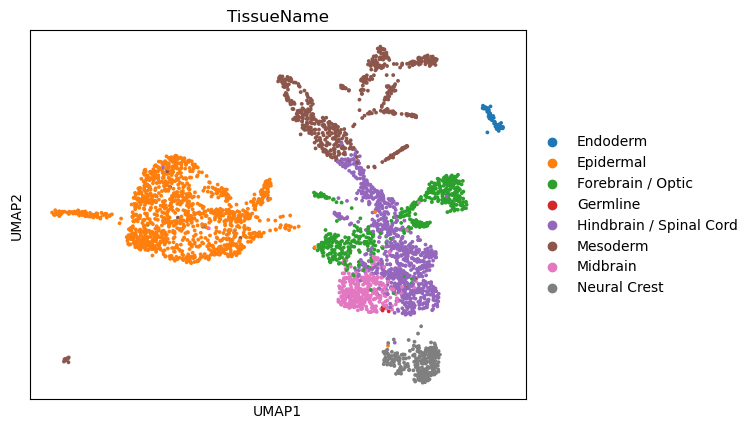

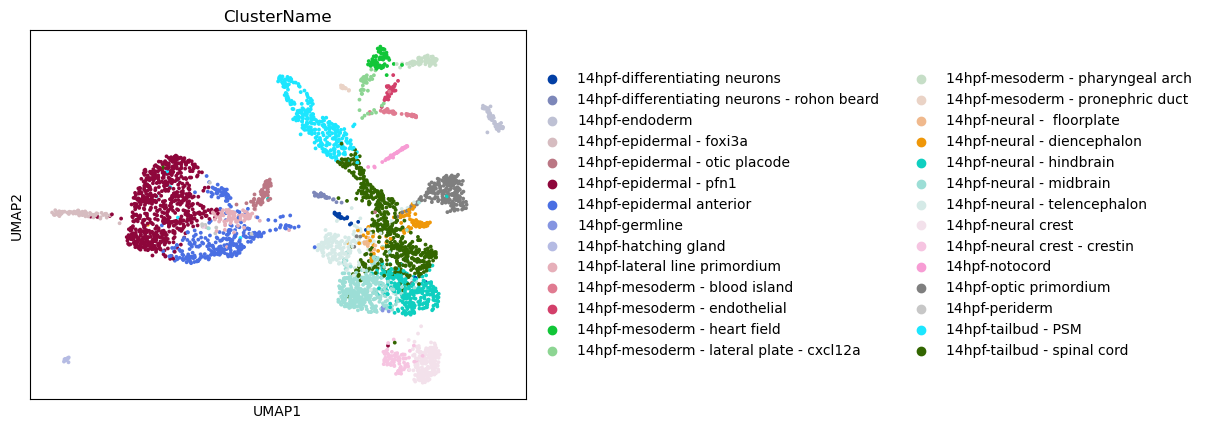

In [6]:
%matplotlib inline
ax = sc.pl.umap(adata_scrna, color=['TissueName'], show=False)
ax = sc.pl.umap(adata_scrna, color=['ClusterName'], show=False)

Filter out cells from clusters that are not present in HCR data

In [7]:
print(len(adata_scrna[adata_scrna.obs.TissueName!='NaN']))
print(len(adata_scrna[adata_scrna.obs.ClusterName=='14hpf-mesoderm - blood island']))
print(len(adata_scrna[adata_scrna.obs.ClusterName=='14hpf-germline']))
print(len(adata_scrna[adata_scrna.obs.TissueName=='Germline']))

4001
43
5
5


C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
adata_scrna = adata_scrna[adata_scrna.obs.TissueName!='NaN']
remove_cluster = ['blood', 'germline']
keep_cell = [all([i not in j for i in remove_cluster]) for j in adata_scrna.obs.ClusterName]

adata_scrna = adata_scrna[keep_cell]
n_scrna_cells = len(adata_scrna.obs)

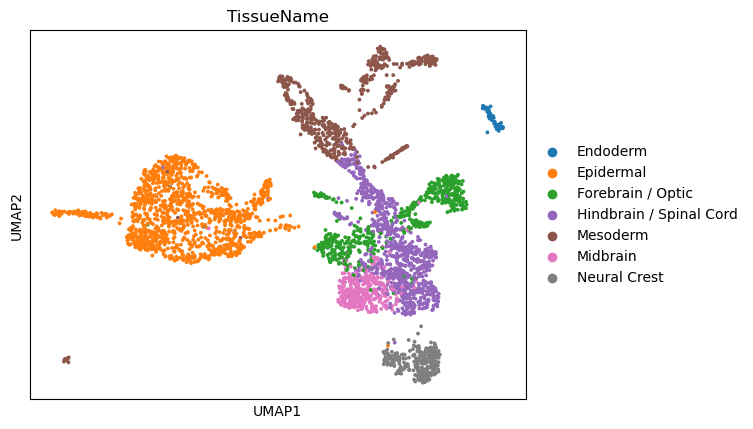

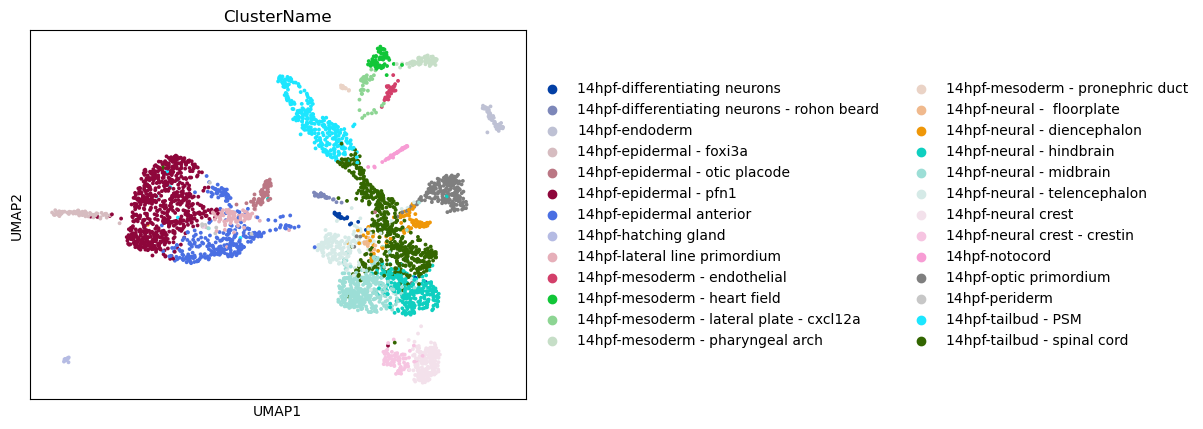

In [9]:
%matplotlib inline
ax = sc.pl.umap(adata_scrna, color=['TissueName'], show=False)
ax = sc.pl.umap(adata_scrna, color=['ClusterName'], show=False)

In [10]:
adata_scrna

View of AnnData object with n_obs × n_vars = 3953 × 5071
    obs: 'n_counts', 'unique_cell_id', 'cell_names', 'library_id', 'batch', 'ClusterID', 'ClusterName', 'TissueID', 'TissueName', 'TimeID'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'ClusterName_colors', 'TissueName_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
adata_scrna.obs

,n_counts,unique_cell_id,cell_names,library_id,batch,ClusterID,ClusterName,TissueID,TissueName,TimeID
index,,,,,,,,,,
0-0-4,17293.0,DEW035_TGATGTTTGAG-AACTTAGC,bcENZK,DEW035,4,75,14hpf-tailbud - spinal cord,3,Hindbrain / Spinal Cord,14hpf
1-0-4,8359.0,DEW035_GAGAGAGTAT-TGCCTCAC,bcCNFS,DEW035,4,52,14hpf-optic primordium,1,Forebrain / Optic,14hpf
2-0-4,5225.0,DEW035_GATGCCATCG-GTTACGAT,bcEECY,DEW035,4,75,14hpf-tailbud - spinal cord,3,Hindbrain / Spinal Cord,14hpf
20-0-4,13968.0,DEW035_AAGTGAAAG-GTTGTCAT,bcFAHA,DEW035,4,51,14hpf-epidermal - pfn1,5,Epidermal,14hpf
21-0-4,8127.0,DEW035_TGATCCAGTCC-ACTAGGAT,bcFYDE,DEW035,4,69,14hpf-mesoderm - pronephric duct,8,Mesoderm,14hpf
...,...,...,...,...,...,...,...,...,...,...
10904-3-4,6241.0,DEW011_GACTTACTCC-ATCCGCTA,bcGADS,DEW011,4,75,14hpf-tailbud - spinal cord,3,Hindbrain / Spinal Cord,14hpf
10926-3-4,6537.0,DEW011_AGCCTCTTT-CACAACAG,bcAFLN,DEW011,4,51,14hpf-epidermal - pfn1,5,Epidermal,14hpf
10948-3-4,5643.0,DEW011_GAATCAAGTG-TACTTGTG,bcDHLC,DEW011,4,64,14hpf-mesoderm - heart field,8,Mesoderm,14hpf


# Rescale HCR values and visualize

In [12]:
adata_hcr.X.shape

(22246, 13)

For all marker genes (i.e. the ones present in the HCR):
- compute min/max values in scRNAseq
- compute 10 and 99.9 percentiles in HCR
- clip values of HCR with its percentiles
- rescale HCR values between 0 and 1
- set all values lower than a otsu threshold to 0 (OPTIONAL)
- rescale values to range of scRNAseq data
- replace the HCR gene expression matrix

In [13]:
from skimage.filters import threshold_otsu

# rescale hcr values to range similar to scrnaseq ones
newX = np.zeros(adata_hcr.X.shape)

for ch in gene_markers:
    # compute min/max values in scRNAseq dataset
    scrna_vals = adata_scrna[:,[ch]].X[:,0]
    scrna_lims = [np.min(scrna_vals), np.max(scrna_vals)]
    
    # compute percentiles in hcr dataset
    hcr_vals = adata_hcr[:,[ch]].X[:,0]
    percs = (3,99.9)
    if ch in ['sox17','foxa2']:
        percs = (3, 99.99)
    hcr_lims = np.percentile(hcr_vals[hcr_vals>0],percs)
    
    # rescale hcr values to 0-1 clipping outliers
    hcr_vals = (hcr_vals-hcr_lims[0])/(hcr_lims[1]-hcr_lims[0])
    hcr_vals = np.clip(hcr_vals,0,1)
    
    # set to 0 all values below a threshold
#     hcr_thr = 2*threshold_otsu(hcr_vals)
#     hcr_vals[hcr_vals<hcr_thr] = 0.

    # rescale hcr values to min/max of scRNAseq dataset
    hcr_vals = hcr_vals*(scrna_lims[1]-scrna_lims[0])+scrna_lims[0]
    
    # append to new matrix
    gene_idx = list(adata_hcr.var_names).index(ch)
    newX[:,gene_idx] = hcr_vals
    
adata_hcr.X = newX

C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
# # subsample hcr dataset
# idxs = list(adata_hcr.obs.sample(4000).index)
# adata_hcr = adata_hcr[[i for i in adata_hcr.obs.index if i in idxs]]

<IPython.core.display.Javascript object>


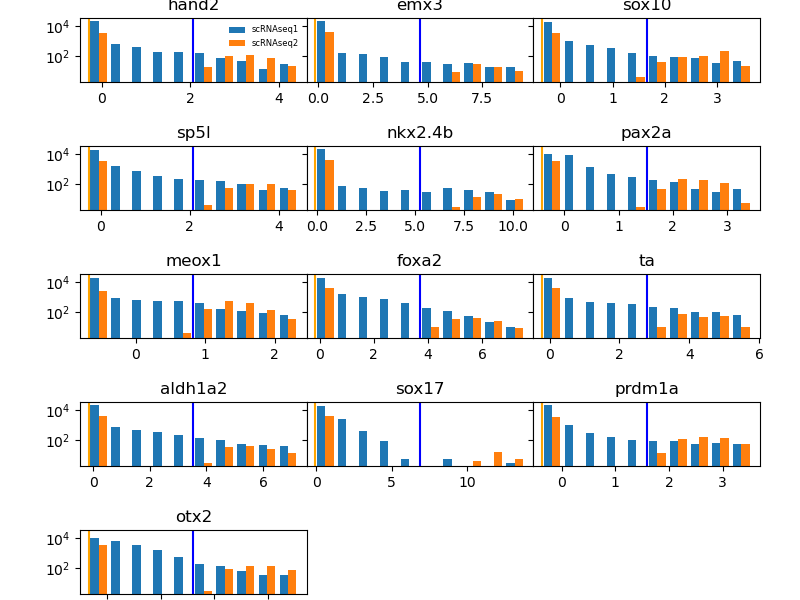

hand2 2.07049298286438 -0.29487923
emx3 4.657700538635254 -0.11482838
sox10 1.652322769165039 -0.350536
sp5l 2.079328775405884 -0.27827275
nkx2.4b 5.257806301116943 -0.090983555
pax2a 1.5176312923431396 -0.4090348
meox1 0.8292348384857178 -0.6793174
foxa2 3.702456474304199 -0.16048712
ta 2.7784225940704346 -0.22058365
aldh1a2 3.5357964038848877 -0.16563243
sox17 6.871830940246582 -0.057972856
prdm1a 1.5847760438919067 -0.36420965
otx2 1.6107484102249146 -0.34774998


In [15]:
from sklearn.cluster import KMeans

reload(funcs)
%matplotlib notebook

fig, ax = funcs.visualize_marker_distribution_adatas(adata_hcr, adata_scrna, 
                                          [i.lower() for i in gene_markers], 
                                          n_cols=3, figsize=(8,6), ylog=True)

for i, g in enumerate(gene_markers):
    g_idx = list(adata_hcr.var_names).index(g)
    hcr_vals = np.array(adata_hcr.X[:,g_idx])
    hcr_thr = (np.max(hcr_vals)+np.min(hcr_vals))/2.
#     hcr_thr = threshold_otsu(hcr_vals)
    ax[i].axvline(hcr_thr, c='blue')

    g_idx = list(adata_scrna.var_names).index(g)
    scrna_vals = np.array(adata_scrna.X[:,g_idx])
    scrna_thr = threshold_otsu(scrna_vals)
    ax[i].axvline(scrna_thr, c='orange')
    
    print(g, hcr_thr, scrna_thr)


Compute how many cells in the HCR data are positive for any of the marker, and will be reasonably mapped.
The cells that are negative to all the markers will be mapped according to their location relative to the marker cells.

NOTE: Uses a simple threshold otsu to define if a cell is positive to a marker, therefore cells that are lowly expressing a certain marker will not be detected.

In [16]:
hcr_thr = {g: 0. for g in gene_markers}

for g in gene_markers:
    g_idx = list(adata_hcr.var_names).index(g)
    hcr_vals = np.array(adata_hcr.X[:,g_idx])
#     hcr_thr[g] = threshold_otsu(hcr_vals)
    hcr_thr[g] = (np.max(hcr_vals)+np.min(hcr_vals))/2.

cell_markers = []
for i, cell in tqdm.tqdm(adata_hcr.obs.iterrows(), total=len(adata_hcr.obs)):
    cell_exp = adata_hcr[cell.name].X[0,:]

    
    is_marker = False
    for g in gene_markers:
        g_idx = list(adata_hcr.var_names).index(g)
        if cell_exp[g_idx]>hcr_thr[g]/2.:
            is_marker = True
            
    if is_marker:
        cell_markers.append(True)
    else:
        cell_markers.append(False)

print('Total number of cells:', len(adata_hcr.obs))
print('Number of marker cells:', np.sum(cell_markers))
print('Num of negative cells:', len(adata_hcr.obs)-np.sum(cell_markers))

100%|██████████████████████████████████████████████████████████████████████████| 22246/22246 [00:09<00:00, 2428.75it/s]

Total number of cells: 22246
Number of marker cells: 9616
Num of negative cells: 12630


**Filter cells in HCR dataset to only contain marker cells!**

In [17]:
adata_hcr = adata_hcr[cell_markers]

Compute how many cells in the scRNAseq data are positive for any of the marker, and will be reasonably mapped.
The cells that are negative to all the markers will be mapped according to their location relative to the marker cells.

NOTE: Uses a simple threshold otsu to define if a cell is positive to a marker, therefore cells that are lowly expressing a certain marker will not be detected.

In [18]:
# scrna_thr = {g: 0. for g in gene_markers}

# for g in gene_markers:
#     g_idx = list(adata_scrna.var_names).index(g)
#     scrna_vals = np.array(adata_scrna.X[:,g_idx])
#     scrna_thr[g] = threshold_otsu(scrna_vals)

cell_markers = 0
for i, cell in tqdm.tqdm(adata_scrna.obs.iterrows(), total=len(adata_scrna.obs)):
    cell_exp = adata_scrna[cell.name].X[0,:]
    
    is_marker = False
    for g in gene_markers:
        g_idx = list(adata_scrna.var_names).index(g)
        if cell_exp[g_idx]>hcr_thr[g]:
            is_marker = True
            
    if is_marker:
        cell_markers += 1

print('Total number of cells:', len(adata_scrna.obs))
print('Number of marker cells:', cell_markers)
print('Num of negative cells:', len(adata_scrna.obs)-cell_markers)

100%|█████████████████████████████████████████████████████████████████████████████| 3953/3953 [00:32<00:00, 121.28it/s]

Total number of cells: 3953
Number of marker cells: 2814
Num of negative cells: 1139


# Use Nearest Neighbor to map cells

Optionally remove one or more marker genes to check the reconstruction using all other genes

In [19]:
print(gene_markers)

#remove sox1
evaluation_genes = ['ta']
gene_markers1 = [i for i in gene_markers if i not in evaluation_genes]

adata_hcr1 = adata_hcr[:,gene_markers1]

print(adata_hcr1)
print(adata_hcr1.var_names)

['hand2', 'emx3', 'sox10', 'sp5l', 'nkx2.4b', 'pax2a', 'meox1', 'foxa2', 'ta', 'aldh1a2', 'sox17', 'prdm1a', 'otx2']
View of AnnData object with n_obs × n_vars = 9616 × 12
    obs: 'x', 'y', 'z', 'density', 'h2bgfp'
Index(['hand2', 'emx3', 'sox10', 'sp5l', 'nkx2.4b', 'pax2a', 'meox1', 'foxa2',
       'aldh1a2', 'sox17', 'prdm1a', 'otx2'],
      dtype='object')


In [20]:
from sklearn.neighbors import NearestNeighbors

In [22]:
ref = np.array(adata_scrna[:,gene_markers1].X)
query = np.array(adata_hcr1[:,gene_markers1].X)

In [23]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(ref)
distances, indices = nbrs.kneighbors(query)

In [24]:
print(len(set(indices[:,0])))
print(len(ref[:,0]))
print(len(set(indices[:,0]))/len(ref[:,0]))


559
3953
0.14141158613711105


In [25]:
query.shape

(9616, 12)

In [26]:
ref.shape

(3953, 12)

In [27]:
X = np.array(adata_scrna.X)[indices[:,0]]
obs = adata_scrna.obs.iloc[indices[:,0]]
obs.index = adata_hcr.obs.index
var = adata_scrna.var

obs = pd.concat([obs, adata_hcr.obs], axis=1)


In [28]:
adata_mapped = ad.AnnData(X, obs=obs, var=var)
adata_mapped.obsm['X_umap'] = adata_scrna.obsm['X_umap'][indices[:,0]]


In [29]:
adata_mapped

AnnData object with n_obs × n_vars = 9616 × 5071
    obs: 'n_counts', 'unique_cell_id', 'cell_names', 'library_id', 'batch', 'ClusterID', 'ClusterName', 'TissueID', 'TissueName', 'TimeID', 'x', 'y', 'z', 'density', 'h2bgfp'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_umap'

<IPython.core.display.Javascript object>


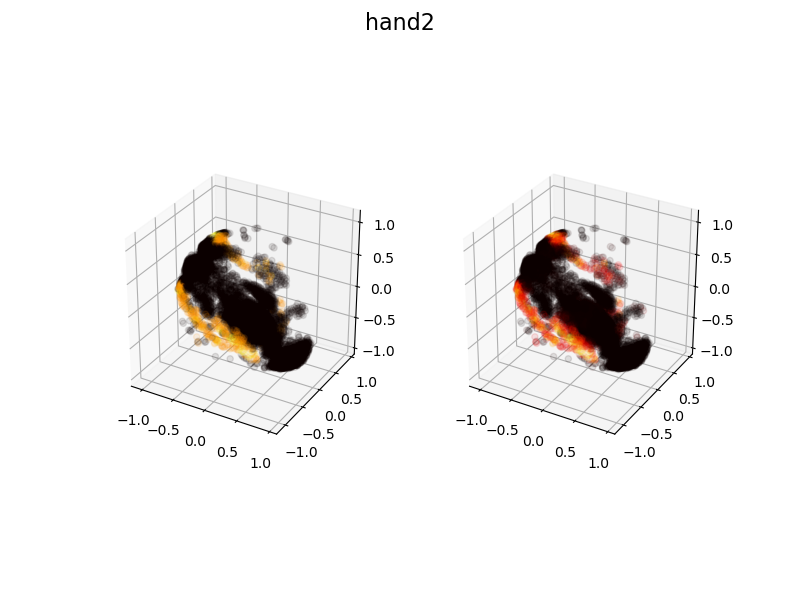

C:\Users\nicol\anaconda3\envs\scaling\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


<IPython.core.display.Javascript object>


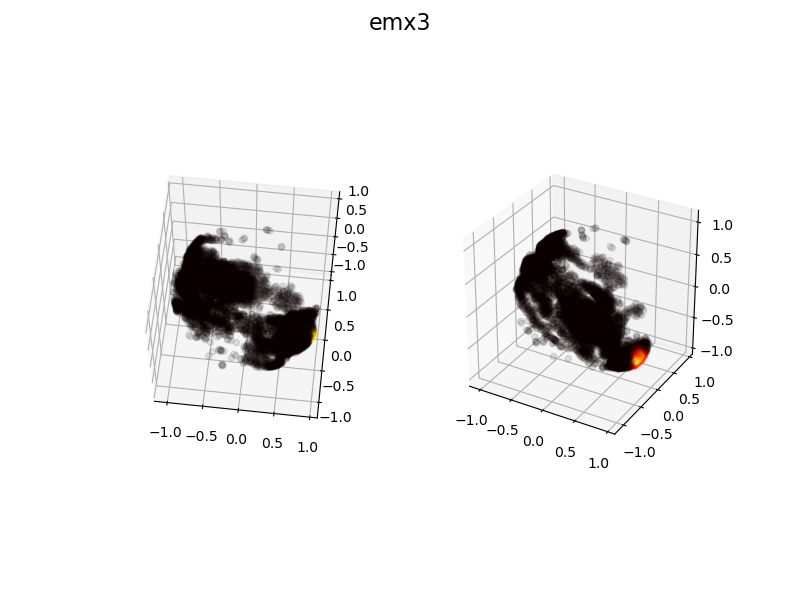

<IPython.core.display.Javascript object>


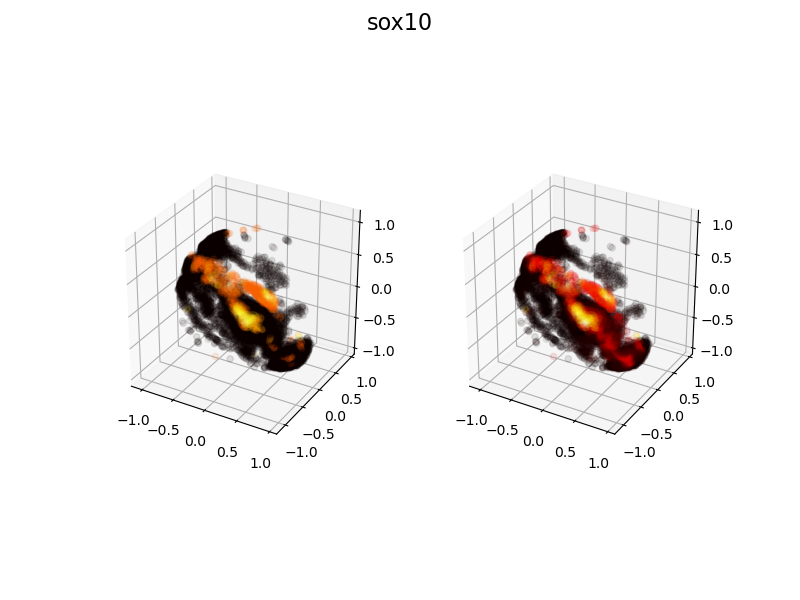

<IPython.core.display.Javascript object>


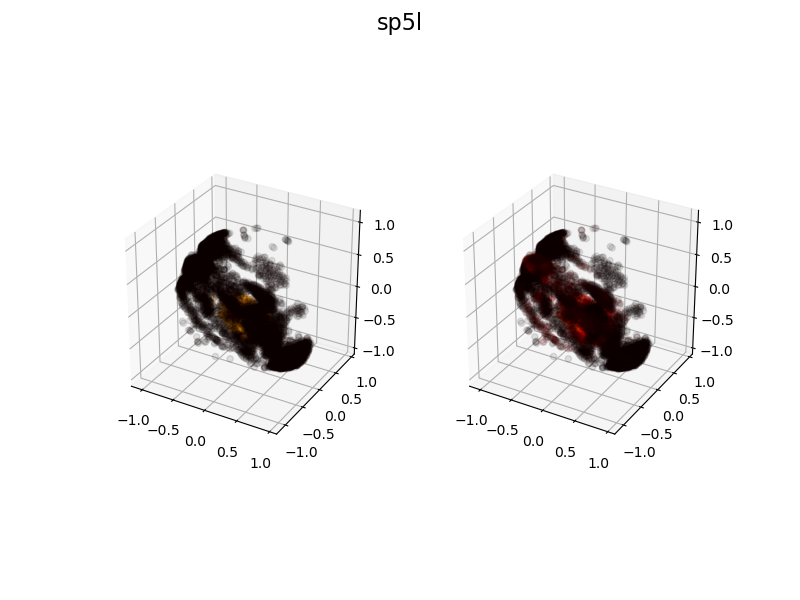

<IPython.core.display.Javascript object>


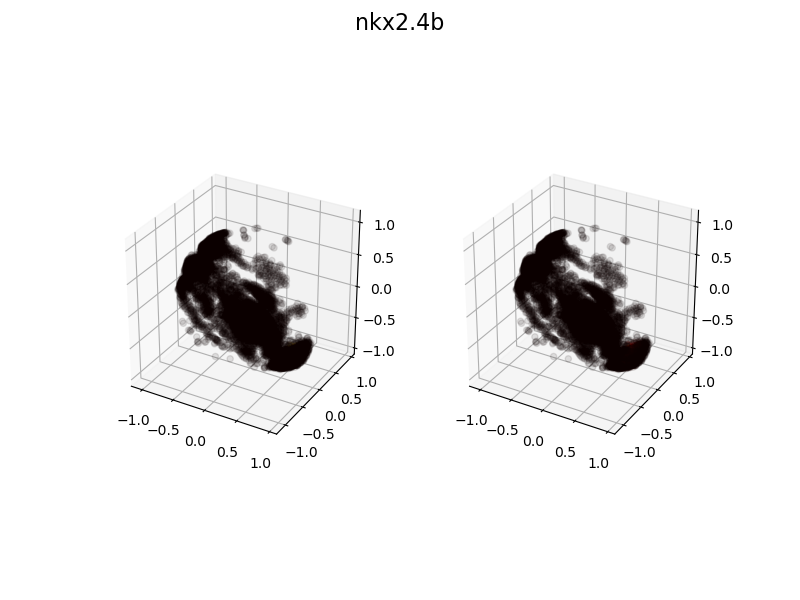

<IPython.core.display.Javascript object>


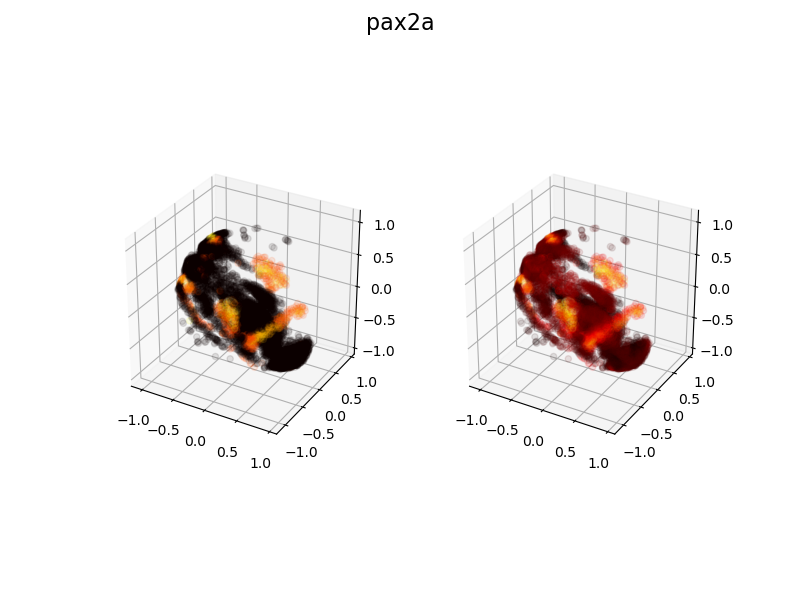

<IPython.core.display.Javascript object>


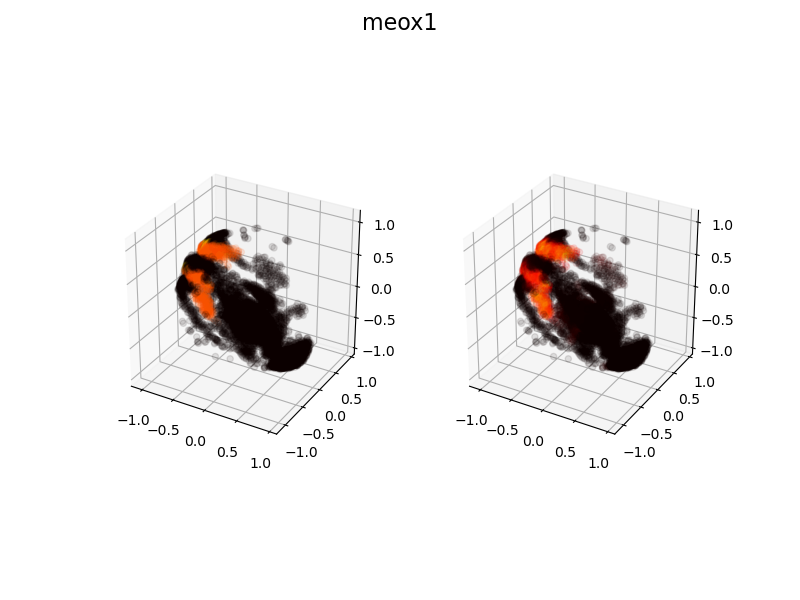

<IPython.core.display.Javascript object>


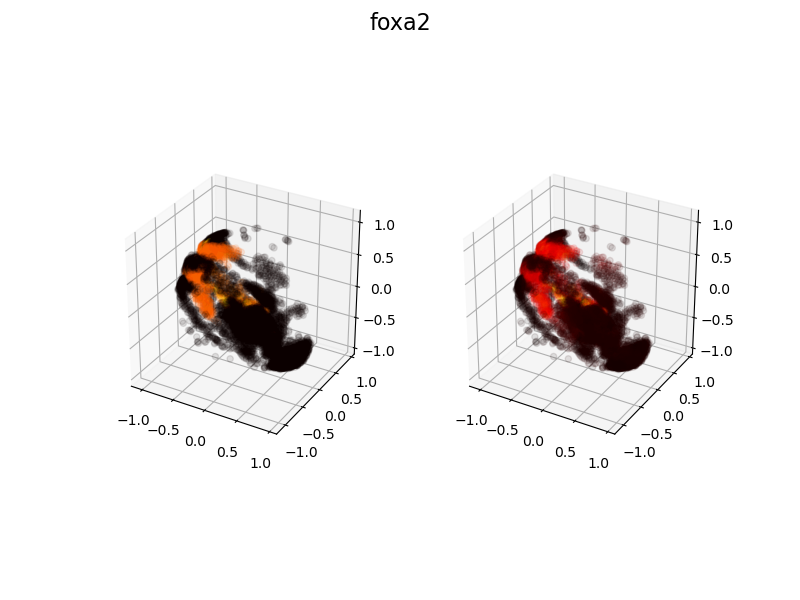

<IPython.core.display.Javascript object>


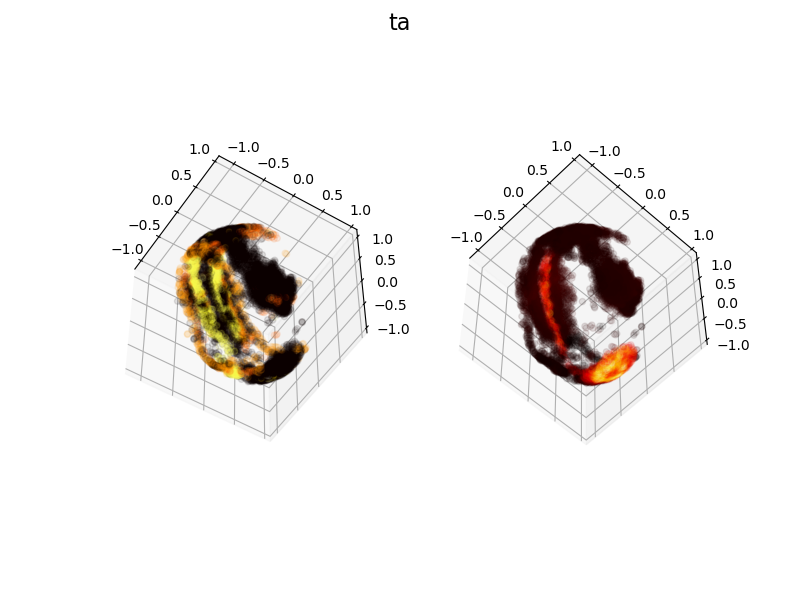

<IPython.core.display.Javascript object>


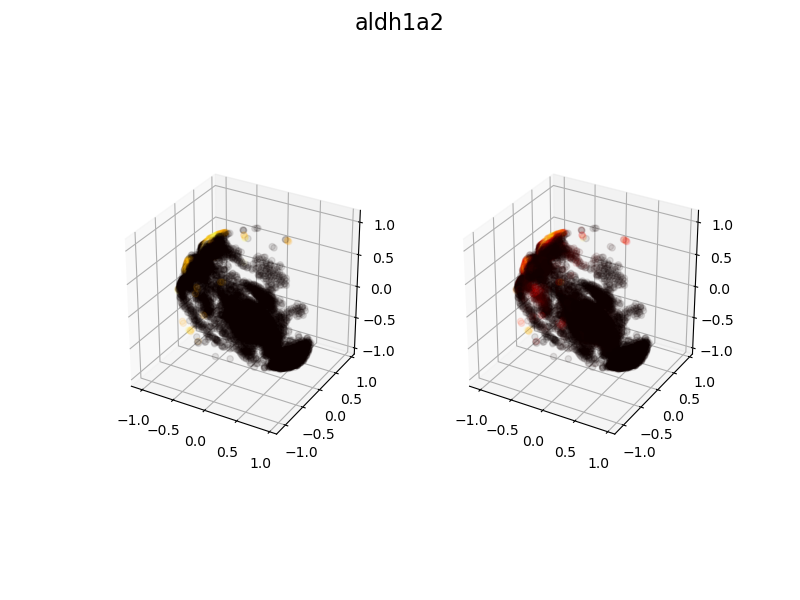

<IPython.core.display.Javascript object>


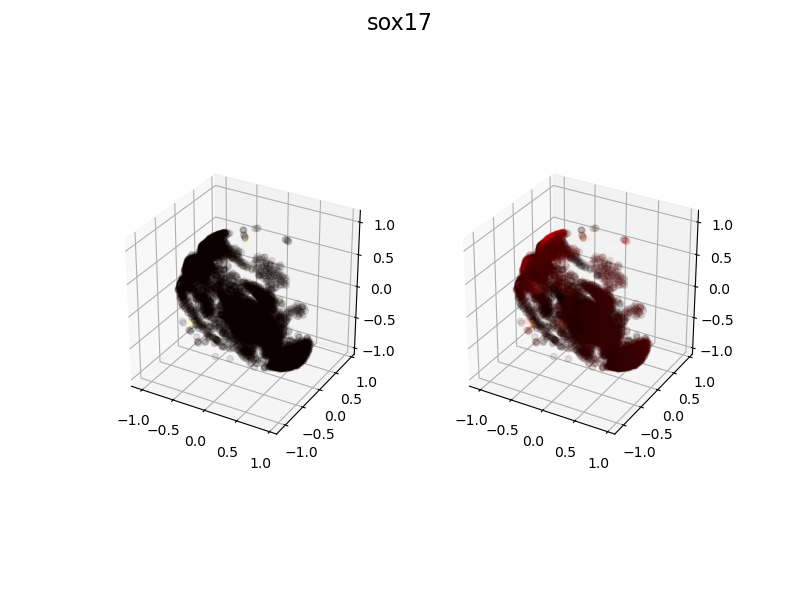

<IPython.core.display.Javascript object>


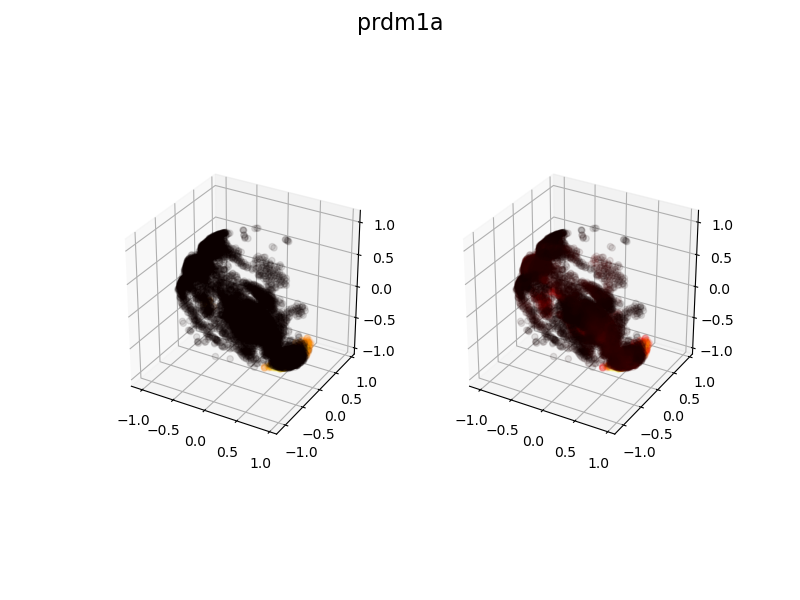

<IPython.core.display.Javascript object>


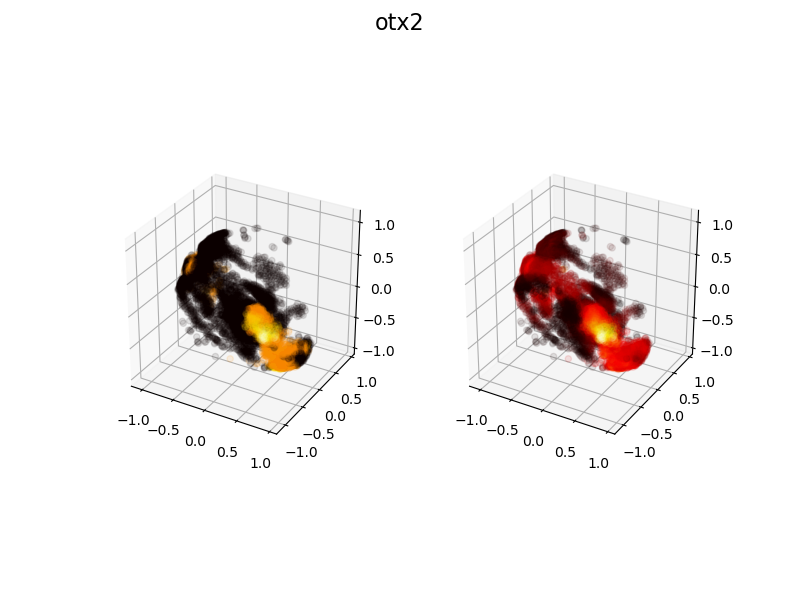

In [30]:
# plot 3D projection to check if all nuclei are more or less found
genes = gene_markers

# fig = plt.figure(figsize=(4,4))
for i in range(len(genes)):
    fig = plt.figure(figsize=(8,6))
    fig.suptitle(genes[i], fontsize=16)
    ax = fig.add_subplot(121,projection='3d')

    # ax.imshow(img_gauss[z])
    p = ax.scatter(
        adata_mapped.obs.x,
        adata_mapped.obs.y,
        adata_mapped.obs.z,
        c=adata_mapped[:,genes[i]].X[:,0],
        alpha=0.1,
        cmap='hot'
    )
    ax.set_box_aspect([1,1,1])
    
    ax = fig.add_subplot(122,projection='3d')

    # ax.imshow(img_gauss[z])
    p = ax.scatter(
        adata_hcr.obs.x,
        adata_hcr.obs.y,
        adata_hcr.obs.z,
        c=adata_hcr[:,genes[i]].X[:,0],
        alpha=0.1,
        cmap='hot'
    )
    ax.set_box_aspect([1,1,1])
#     fig.colorbar(p)

#     set_axes_equal(ax)


In [31]:
mapped_name = os.path.join(os.path.split(hcr_file)[0], 
                           'NN_mapped_hpf'+str(hpf)+'.h5')
adata_mapped.write(filename=mapped_name)

... storing 'unique_cell_id' as categorical
